### Anomaly detection Problem on ECG Dataset
In this task, we are going to train a model to detect anomalies in the
[ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

In the dataset, each example has been labeled either 0 (corresponding to an abnormal rhythm (anomaly)), or 1 (corresponding to a normal rhythm (Normal)). we are interested in identifying the abnormal rhythms.

In [1]:
# importing necessary librarise...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

##Load ECG data

In [2]:

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header = None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
print("Shape of the dataset:", dataframe.shape)

Shape of the dataset: (4998, 141)


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [7]:
# number of Null / NaN values in the dataset
dataframe.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
136    0
137    0
138    0
139    0
140    0
Length: 141, dtype: int64

###How will you detect anomalies using an autoencoder?
***Firstly:*** An autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms (Non-anomaly/normal data) only, then use it to reconstruct all the data.

***Secondly***: Our hypothesis is that the abnormal rhythms (abnormal data-points) will have higher reconstruction error. You will then classify a rhythm (example) as an anomaly if the reconstruction error surpasses (greater) a fixed threshold.

In [8]:
# converting dataframe into numpy array.
raw_data = dataframe.values

In [9]:
print("Type of raw_data:", type(raw_data))
raw_data.shape

Type of raw_data: <class 'numpy.ndarray'>


(4998, 141)

In [11]:
## Seperating feature and lable columns

# The last element contains the labels
labels = raw_data[:, -1] # last column

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

In [13]:
# first five samples
print("First five example:\n", data[0:3])

print("Shape of a single example:", data[0].shape)

First five example:
 [[-1.1252183e-01 -2.8272038e+00 -3.7738969e+00 -4.3497511e+00
  -4.3760410e+00 -3.4749863e+00 -2.1814082e+00 -1.8182865e+00
  -1.2505219e+00 -4.7749208e-01 -3.6380791e-01 -4.9195659e-01
  -4.2185509e-01 -3.0920086e-01 -4.9593870e-01 -3.4211867e-01
  -3.5533627e-01 -3.6791303e-01 -3.1650279e-01 -4.1237405e-01
  -4.7167181e-01 -4.1345783e-01 -3.6461703e-01 -4.4929829e-01
  -4.7141866e-01 -4.2477658e-01 -4.6251673e-01 -5.5247236e-01
  -4.7537519e-01 -6.9420000e-01 -7.0186810e-01 -5.9381178e-01
  -6.6068415e-01 -7.1383066e-01 -7.6980688e-01 -6.7228161e-01
  -6.5367605e-01 -6.3940562e-01 -5.5930228e-01 -5.9167032e-01
  -4.9322332e-01 -4.6305183e-01 -3.0164382e-01 -2.3273401e-01
  -1.2505488e-01 -1.5394314e-01 -2.4357404e-02 -6.5608758e-02
   3.4999258e-02  6.1935219e-02  7.1195420e-02  1.2392505e-01
   1.0312371e-01  2.2522849e-01  1.2868305e-01  3.0248315e-01
   2.5727621e-01  1.9635161e-01  1.7938297e-01  2.4472863e-01
   3.4121687e-01  3.2820441e-01  4.0604169e-01  4

In [14]:
print("Shape of the lable:",labels.shape)
type(labels)

Shape of the lable: (4998,)


numpy.ndarray

### Splitting the data into train and test sets.

In [15]:
# Splitting data into 80% training and 20% test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [16]:
print("Shape of the train_data:", train_data.shape)
print("Shape of the train_labels:", train_labels.shape)

print("Shape of the test_data:", test_data.shape)
print("Shape of the test_labels:", test_labels.shape)


Shape of the train_data: (3998, 140)
Shape of the train_labels: (3998,)
Shape of the test_data: (1000, 140)
Shape of the test_labels: (1000,)


In [26]:
print(f"Train-set after shuffled:\n{train_labels[:5]}")
print("Unique values in train-set labels ",np.unique( train_labels ) )

print(f"Test-set after shuffled:\n{test_labels[:5]}")
print("Unique values in test-set labels ",np.unique( test_labels ) )

Train-set after shuffled:
[1. 0. 1. 1. 0.]
Unique values in train-set labels  [0. 1.]
Test-set after shuffled:
[1. 1. 1. 0. 0.]
Unique values in test-set labels  [0. 1.]


### Normalizing the data to [0, 1]

In [27]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

print("Minimum value in the train set:", np.array(min_val))
print("Maximum value in the train set:", np.array(max_val))

Minimum value in the train set: -6.2808752
Maximum value in the train set: 7.4021031


In [28]:
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

In [29]:
print("After normalization, min and max value in train set:",np.array(train_data).min(), np.array(train_data).max())
print("After normalization, min and max value: in test set",np.array(test_data).min(), np.array(test_data).max())

After normalization, min and max value in train set: 0.0 1.0
After normalization, min and max value: in test set -0.0591610161363773 0.7499388638217749


In [30]:
# casting values into float32
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [31]:
## We will train the autoencoder using only the normal rhythms (Not-anomaly), which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.
print("Unique values in train_labels:",np.unique( train_labels ))
print("Unique values in test_labels:",np.unique( test_labels ))

Unique values in train_labels: [0. 1.]
Unique values in test_labels: [0. 1.]


### Seperating normal (Not-Anomaly) and abnormal (Anomaly) data-points

In [32]:
print("Calss Distribution in train set:\n", pd.DataFrame(train_labels).value_counts())
print("Calss Distribution in test set:\n", pd.DataFrame(test_labels).value_counts())

Calss Distribution in train set:
 1.0    2328
0.0    1670
dtype: int64
Calss Distribution in test set:
 1.0    591
0.0    409
dtype: int64


In [33]:
# Converting train and test lables into boolean data-type.
train_labels = train_labels.astype( bool )
test_labels = test_labels.astype( bool )

In [37]:
print("First five boolean values of train-set:", train_labels[:5] )

First five boolean values of train-set: [ True False  True  True False]


In [38]:
# seperating normal (Not-Anomaly) and abnormal (Anomaly) data-points from both training and test datasets.
normal_train_data = train_data[train_labels]
anomalous_train_data = train_data[~train_labels]

# normal and anomalous data-points from the test-data
normal_test_data = test_data[test_labels]
anomalous_test_data = test_data[~test_labels]

In [40]:
print("Number of normal data-points in training set:",normal_train_data.shape)
print("Number of abnormal (anomaly) data-points in training set:",anomalous_train_data.shape)

print("Number of normal data-points in test set:",normal_test_data.shape)
print("Number of abnormal (anomaly) data-points in test set:",anomalous_test_data.shape)

Number of normal data-points in training set: (2328, 140)
Number of abnormal (anomaly) data-points in training set: (1670, 140)
Number of normal data-points in test set: (591, 140)
Number of abnormal (anomaly) data-points in test set: (409, 140)


In [41]:
# plotting normal ECG (as line plot)
print("First Normal data-point (example) in training set:", normal_train_data[0])

First Normal data-point (example) in training set: tf.Tensor(
[0.51649326 0.39186087 0.27047953 0.17162749 0.13925761 0.18622579
 0.2791653  0.33577576 0.3444735  0.4016197  0.43095002 0.4220101
 0.42269725 0.4266005  0.42612928 0.4304366  0.42668477 0.42549065
 0.42553097 0.4187498  0.42426157 0.4192829  0.4113667  0.41708657
 0.41535234 0.41234994 0.4077595  0.40133128 0.39872435 0.39671192
 0.38447797 0.38383502 0.38145635 0.38296193 0.38079625 0.3823782
 0.3820329  0.38918608 0.39048707 0.3927454  0.40374237 0.40600425
 0.41641498 0.42011565 0.4291107  0.44477692 0.4504089  0.44588187
 0.4473734  0.4560804  0.4473142  0.44851372 0.45356414 0.45746785
 0.46944082 0.46371654 0.4595216  0.4668247  0.4664597  0.46837318
 0.46731806 0.47522426 0.47740597 0.47590044 0.47813973 0.4811637
 0.4872817  0.48851788 0.49119008 0.49213842 0.49981225 0.50164616
 0.50238436 0.5056529  0.49646077 0.5020262  0.5045791  0.50032496
 0.4975984  0.5015623  0.5030343  0.49379772 0.4959412  0.49069875
 0.

In [46]:
np.random.randint(0, len(train_labels-5), size = 3)

778

Random samples index: [1930  865 1538]


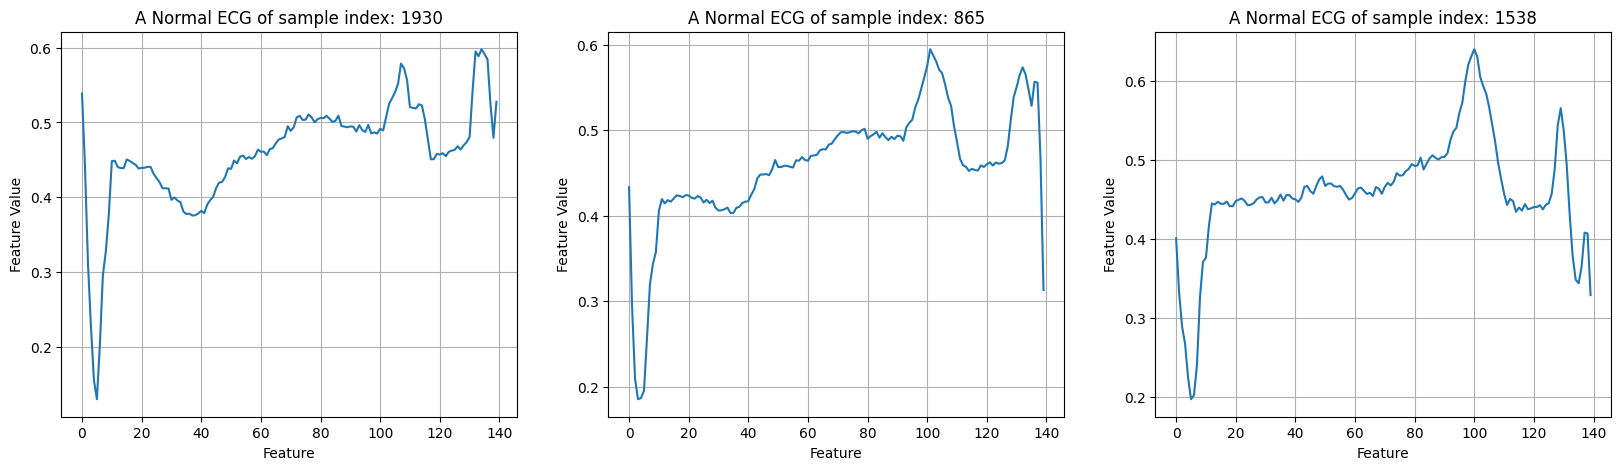

In [49]:
random_sample_index = np.random.randint(0, normal_train_data.shape[0]-5, size = 3)
print(f"Random samples index: {random_sample_index}")

plt.figure(figsize = (20, 5))

# adding first subplot
plt.subplot(131)
plt.grid()
plt.plot( np.arange(140), normal_train_data[ random_sample_index[0] ] )
plt.title(f"A Normal ECG of sample index: {random_sample_index[0]}")
plt.xlabel("Feature")
plt.ylabel("Feature Value")

# adding second subplot
plt.subplot(132)
plt.grid()
plt.plot( np.arange(140), normal_train_data[ random_sample_index[1] ] )
plt.title(f"A Normal ECG of sample index: {random_sample_index[1]}")
plt.xlabel("Feature")
plt.ylabel("Feature Value")

plt.subplot(133)
plt.grid()
plt.plot( np.arange(140), normal_train_data[ random_sample_index[2] ] )
plt.title(f"A Normal ECG of sample index: {random_sample_index[2]}")
plt.xlabel("Feature")
plt.ylabel("Feature Value")

plt.show()

Random samples index of anomalous_train data: [759 895 669]


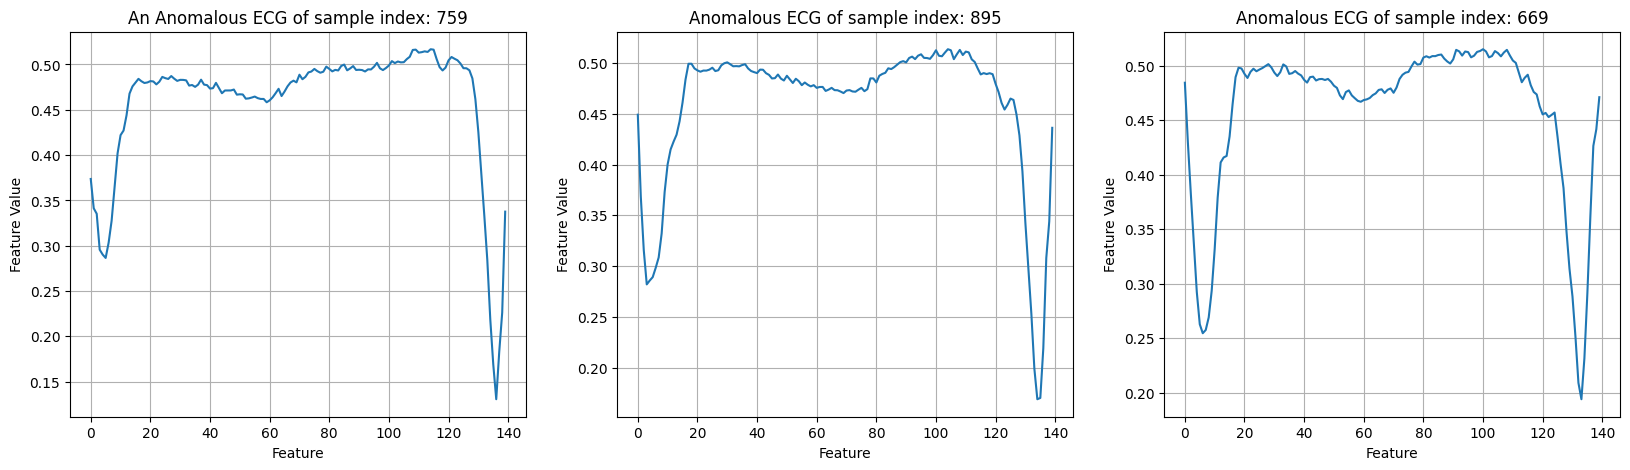

In [51]:
random_sample_index = np.random.randint(0, anomalous_train_data.shape[0]-5, size = 3)
print(f"Random samples index of anomalous_train data: {random_sample_index}")

## Plotting an anomalous (abnormal) ECG.
plt.figure(figsize = (20,5))

# adding first subplot
plt.subplot(131)
plt.grid()
plt.plot( np.arange(140), anomalous_train_data[ random_sample_index[0] ] )
plt.title(f"An Anomalous ECG of sample index: {random_sample_index[0]}")
plt.xlabel("Feature")
plt.ylabel("Feature Value")

# adding second subplot
plt.subplot(132)
plt.grid()
plt.plot( np.arange(140), anomalous_train_data[ random_sample_index[1] ] )
plt.title(f"Anomalous ECG of sample index: {random_sample_index[1]}")
plt.xlabel("Feature")
plt.ylabel("Feature Value")

plt.subplot(133)
plt.grid()
plt.plot( np.arange(140), anomalous_train_data[ random_sample_index[2] ] )
plt.title(f"Anomalous ECG of sample index: {random_sample_index[2]}")
plt.xlabel("Feature")
plt.ylabel("Feature Value")

plt.show()

### Building the AutoEnconder model

In [61]:
#  creating a new class
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()

    # Encoder section (Encoding section contains 4 Dense layers)
    self.encoder = tf.keras.Sequential([
      layers.Dense(units = 32, activation = "relu"),
      layers.Dense(units = 16, activation = "relu"),
      layers.Dense(units = 8, activation = "relu")
      ])

    # Decoder section
    self.decoder = tf.keras.Sequential([
      layers.Dense(units = 16, activation = "relu"),
      layers.Dense(units = 32, activation = "relu"),
      layers.Dense(units = 140, activation = "sigmoid")
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [65]:
# creating an object of the class
autoencoder = AnomalyDetector()

In [66]:
# compling the model
autoencoder.compile(optimizer = 'RMSprop', loss = 'mae')

In [68]:
# Notice that the autoencoder is trained using only the normal (Not-Anamoly) ECGs, but is evaluated using the full test set.
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs = 20,
          batch_size = 256,
          validation_data = (test_data, test_data),
          shuffle = True)

Epoch 1/20
10/10 [==============================] - 1s 24ms/step - loss: 0.0565 - val_loss: 0.0515
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0526 - val_loss: 0.0487
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0477 - val_loss: 0.0456
Epoch 4/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0418 - val_loss: 0.0426
Epoch 5/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0360 - val_loss: 0.0399
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0311 - val_loss: 0.0377
Epoch 7/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0274 - val_loss: 0.0364
Epoch 8/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.0354
Epoch 9/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0235 - val_loss: 0.0348
Epoch 10/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0221 - val_loss: 0.0333
Epoch 11/20
10/10 

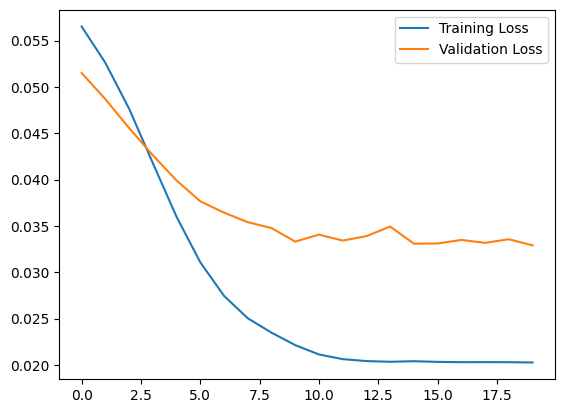

In [69]:
# plotting loss curve
plt.plot( history.history["loss"], label = "Training Loss" )
plt.plot( history.history["val_loss"], label = "Validation Loss" )
plt.legend()

In [72]:
# Encoder section summary
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 32)                4512      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 8)                 136       
                                                                 
Total params: 5,176
Trainable params: 5,176
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Decoder section summary
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                144       
                                                                 
 dense_26 (Dense)            (None, 32)                544       
                                                                 
 dense_27 (Dense)            (None, 140)               4620      
                                                                 
Total params: 5,308
Trainable params: 5,308
Non-trainable params: 0
_________________________________________________________________


### Plotting Normal (Not- anomaly) ECG samples.

In [74]:
# lets plotting one training example, reconstruction after encoded and encoced and reconstruction error
encoded_data = autoencoder.encoder( normal_test_data ).numpy() # normal ECG data-point (applying encoding)
decoded_data = autoencoder.decoder( encoded_data ).numpy()  # applying decoding

In [80]:
print("First Normal sample (data-point) of the  in test set:\n", normal_test_data[0])

First Normal sample (data-point) of the  in test set:
 tf.Tensor(
[0.69334304 0.5924179  0.39133146 0.2796536  0.19448799 0.18705189
 0.27406523 0.369904   0.36472237 0.41697812 0.4990636  0.50177574
 0.50328124 0.50136495 0.5078209  0.49741176 0.5017855  0.506236
 0.49925795 0.49716455 0.4898293  0.4850731  0.48455733 0.47866583
 0.47424838 0.4746194  0.47336382 0.45550293 0.45413882 0.4507704
 0.43459395 0.44415236 0.42111462 0.42555594 0.42356417 0.4208878
 0.41312873 0.4203056  0.42079407 0.4209925  0.4214177  0.42396894
 0.44413957 0.44710043 0.45075125 0.46663833 0.47411895 0.48879656
 0.48568916 0.4791158  0.48117635 0.48614034 0.48797572 0.48686945
 0.49733222 0.48746732 0.49449444 0.4946199  0.48511973 0.48819616
 0.48867702 0.4890224  0.4869044  0.49109852 0.5013652  0.49111992
 0.4950854  0.49460077 0.49883232 0.49718386 0.50772285 0.4974831
 0.509644   0.50710183 0.50834984 0.51392037 0.5144454  0.5141417
 0.51273096 0.5086645  0.5043938  0.5052921  0.4978129  0.49938646
 0

In [81]:
print("First Reconstructed sample (data-point) of the  in test set:\n", decoded_data[0])

First Reconstructed sample (data-point) of the  in test set:
 [0.4340145  0.2987531  0.21804294 0.16477753 0.18118401 0.22485417
 0.30218232 0.34359366 0.3705532  0.4120503  0.4374124  0.44607335
 0.44726053 0.44434306 0.44847277 0.4476808  0.4462168  0.44562712
 0.4431589  0.44256324 0.43919575 0.4379085  0.4372616  0.43575758
 0.43460813 0.42808908 0.4253153  0.4240666  0.42411387 0.418956
 0.41737238 0.4151667  0.411087   0.40996403 0.40804482 0.40150613
 0.40896899 0.41126332 0.40742362 0.40774134 0.4160496  0.42174423
 0.42699462 0.43543357 0.4364034  0.4449826  0.4500919  0.45915753
 0.45737588 0.46237049 0.46388927 0.46247518 0.4674598  0.46559602
 0.46939048 0.4675153  0.46879274 0.47030136 0.47092336 0.46815538
 0.46853063 0.47215262 0.47277787 0.47297207 0.47366473 0.47909462
 0.48362586 0.48337907 0.48848218 0.49110416 0.4923558  0.4983002
 0.49660066 0.4945975  0.5021597  0.5008114  0.50660944 0.50411654
 0.50153166 0.4982722  0.50087136 0.4999272  0.4932737  0.49515286
 0.

Random samples index of normal_test data: [407 580 276]


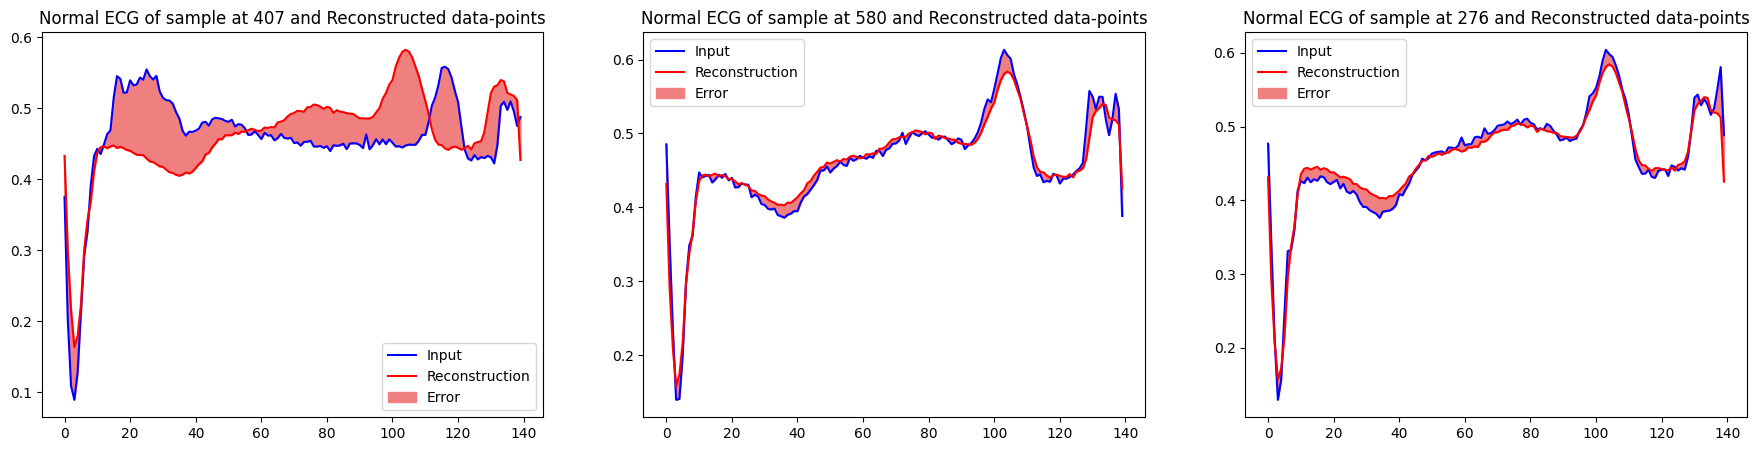

In [90]:
random_sample_index = np.random.randint(0, normal_test_data.shape[0]-5, size = 3)
print(f"Random samples index of normal_test data: {random_sample_index}")

plt.figure(figsize = (22,5))

# Subplot 1: Normal (actual) and reconstracted data-point
plt.subplot(131)
plt.plot( normal_test_data[ random_sample_index[0] ], 'b' )
plt.plot(decoded_data[ random_sample_index[0] ], 'r')
plt.fill_between(np.arange(140), decoded_data[ random_sample_index[0] ], normal_test_data[ random_sample_index[0] ], color = 'lightcoral')

plt.title(f"Normal ECG of sample at {random_sample_index[0]} and Reconstructed data-points")
plt.legend(labels = ["Input", "Reconstruction", "Error"])

# Subplot 2: Normal (actual) and reconstracted data-point
plt.subplot(132)
plt.plot( normal_test_data[ random_sample_index[1] ], 'b' )
plt.plot(decoded_data[ random_sample_index[1] ], 'r')
plt.fill_between(np.arange(140), decoded_data[ random_sample_index[1] ], normal_test_data[ random_sample_index[1] ], color = 'lightcoral')

plt.title(f"Normal ECG of sample at {random_sample_index[1]} and Reconstructed data-points")
plt.legend(labels = ["Input", "Reconstruction", "Error"])

# Subplot 3: Normal (actual) and reconstracted data-point
plt.subplot(133)
plt.plot( normal_test_data[ random_sample_index[2] ], 'b' )
plt.plot(decoded_data[ random_sample_index[2] ], 'r')
plt.fill_between(np.arange(140), decoded_data[ random_sample_index[2] ], normal_test_data[ random_sample_index[2] ], color = 'lightcoral')

plt.title(f"Normal ECG of sample at {random_sample_index[2]} and Reconstructed data-points")
plt.legend(labels = ["Input", "Reconstruction", "Error"])


plt.show()

### Plotting Anomalous (Not-Normal) ECG samples.

In [ ]:
# Create a similar plot, this time for an anomalous (Anamoly) test example
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

Random samples index of anomalous_test data: [124  24  49]


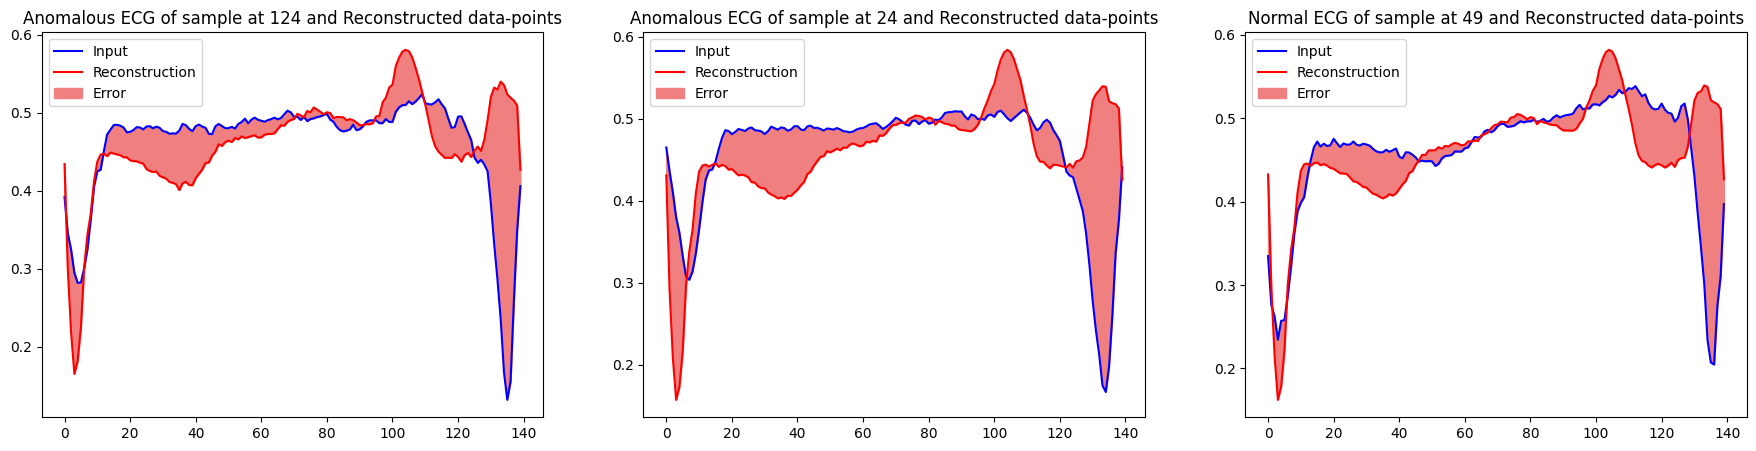

In [91]:
random_sample_index = np.random.randint(0, anomalous_test_data.shape[0]-5, size = 3)
print(f"Random samples index of anomalous_test data: {random_sample_index}")

## Plotting an anomalous (abnormal) ECG.
plt.figure(figsize = (22, 5))

# Subplot 1: Anomolous (Anamoly) and reconstracted data-point
plt.subplot(131)
plt.plot( anomalous_test_data[ random_sample_index[0] ], 'b' )
plt.plot( decoded_data[ random_sample_index[0] ], 'r' )
plt.fill_between(np.arange(140), decoded_data[ random_sample_index[0] ], anomalous_test_data[ random_sample_index[0] ], color = 'lightcoral')

plt.title(f"Anomalous ECG of sample at {random_sample_index[0]} and Reconstructed data-points")
plt.legend(labels = ["Input", "Reconstruction", "Error"])

# Subplot 2: Anomolous (Anamoly) and reconstracted data-point
plt.subplot(132)
plt.plot( anomalous_test_data[ random_sample_index[1] ], 'b' )
plt.plot( decoded_data[ random_sample_index[1] ], 'r' )
plt.fill_between(np.arange(140), decoded_data[ random_sample_index[1] ], anomalous_test_data[ random_sample_index[1] ], color = 'lightcoral')

plt.title(f"Anomalous ECG of sample at {random_sample_index[1]} and Reconstructed data-points")
plt.legend(labels = ["Input", "Reconstruction", "Error"])

# Subplot 3: Anomolous (Anamoly) and reconstracted data-point
plt.subplot(133)
plt.plot( anomalous_test_data[ random_sample_index[2] ], 'b' )
plt.plot(decoded_data[ random_sample_index[2] ], 'r')
plt.fill_between(np.arange(140), decoded_data[ random_sample_index[2] ], anomalous_test_data[ random_sample_index[2] ], color = 'lightcoral')

plt.title(f"Normal ECG of sample at {random_sample_index[2]} and Reconstructed data-points")
plt.legend(labels = ["Input", "Reconstruction", "Error"])


plt.show()

### Detect anomalies

In [95]:
# Rule for detecting anomalies:
# Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

reconstructions = autoencoder.predict( normal_train_data )
train_loss = tf.keras.losses.mae( reconstructions, normal_train_data )

print("First two samples of normal_train_data:\n", normal_train_data[0:2, :])
print("Two reconstruction samples:\n", reconstructions[0:2, :])

73/73 [==============================] - 0s 2ms/step
First two samples of normal_train_data:
 tf.Tensor(
[[0.51649326 0.39186087 0.27047953 0.17162749 0.13925761 0.18622579
  0.2791653  0.33577576 0.3444735  0.4016197  0.43095002 0.4220101
  0.42269725 0.4266005  0.42612928 0.4304366  0.42668477 0.42549065
  0.42553097 0.4187498  0.42426157 0.4192829  0.4113667  0.41708657
  0.41535234 0.41234994 0.4077595  0.40133128 0.39872435 0.39671192
  0.38447797 0.38383502 0.38145635 0.38296193 0.38079625 0.3823782
  0.3820329  0.38918608 0.39048707 0.3927454  0.40374237 0.40600425
  0.41641498 0.42011565 0.4291107  0.44477692 0.4504089  0.44588187
  0.4473734  0.4560804  0.4473142  0.44851372 0.45356414 0.45746785
  0.46944082 0.46371654 0.4595216  0.4668247  0.4664597  0.46837318
  0.46731806 0.47522426 0.47740597 0.47590044 0.47813973 0.4811637
  0.4872817  0.48851788 0.49119008 0.49213842 0.49981225 0.50164616
  0.50238436 0.5056529  0.49646077 0.5020262  0.5045791  0.50032496
  0.4975984  0

In [98]:
train_loss[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.012088607>

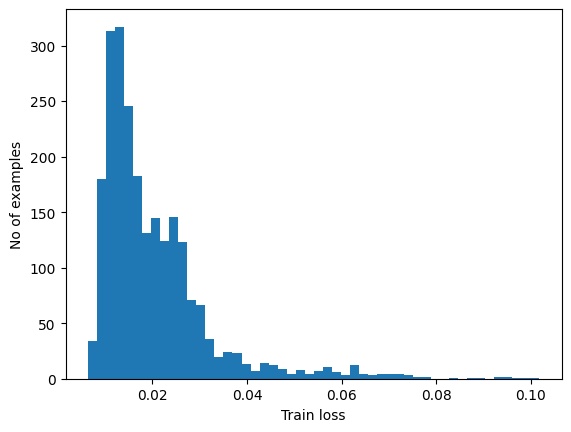

In [99]:
plt.hist(train_loss[None,:], bins = 50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [100]:
# Choose a threshold value that is one standard deviations above the mean.

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032428782


In [102]:
# If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold.

# making predictions on anomalous test data.
reconstructions = autoencoder.predict( anomalous_test_data )
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data) # test error using MAE

print(f"First two samples of anomalous_test_data:\n", anomalous_test_data[0:2, :])
print("First two reconstructed data-points:\n", reconstructions[0:2, :])

13/13 [==============================] - 0s 5ms/step
First two samples of anomalous_test_data:
 tf.Tensor(
[[0.5021547  0.4841796  0.42331892 0.35886806 0.32288897 0.26512522
  0.22365533 0.21579568 0.23570567 0.2674926  0.3147769  0.35233143
  0.35626617 0.36369044 0.39681494 0.43288758 0.44359723 0.43880486
  0.43718427 0.4413374  0.43498597 0.44082966 0.44648096 0.4419437
  0.44342065 0.44532377 0.4364067  0.44298247 0.44052425 0.4361226
  0.44058242 0.44530553 0.4376158  0.43303427 0.43606144 0.4376559
  0.448175   0.43631634 0.43349692 0.43171087 0.43178746 0.43170407
  0.43376818 0.42535695 0.4206084  0.42262417 0.42645773 0.4206362
  0.41904715 0.41266868 0.41541    0.42072254 0.41405067 0.4162786
  0.40508205 0.40593112 0.4146048  0.4106584  0.4089714  0.4047074
  0.41099712 0.40654552 0.40852985 0.4130769  0.41057956 0.416818
  0.423158   0.42627564 0.43268064 0.43343735 0.4393434  0.4450524
  0.45069465 0.44784173 0.4417598  0.45216292 0.45407003 0.4566396
  0.46092063 0.4621

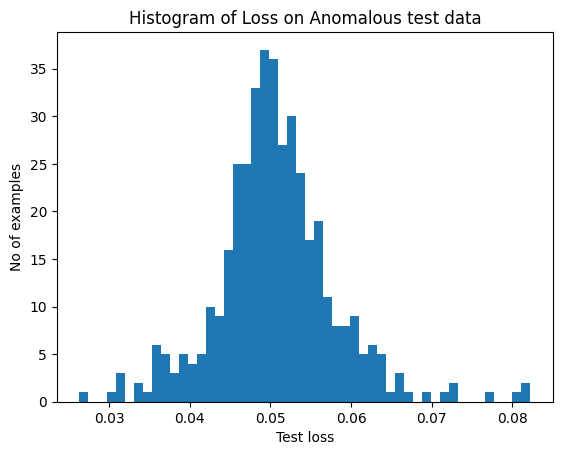

In [103]:
plt.hist(test_loss[None, :], bins = 50)

plt.title("Histogram of Loss on Anomalous test data")
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [118]:
anomalous_test_data_df = pd.DataFrame( anomalous_test_data.numpy() )
anomalous_test_data_df['Reconstruction Loss'] = test_loss
anomalous_test_data_df["Prediction"] = test_loss > threshold

anomalous_test_data_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,Reconstruction Loss,Prediction
0,0.502155,0.484180,0.423319,0.358868,0.322889,0.265125,0.223655,0.215796,0.235706,0.267493,...,0.588060,0.640774,0.654242,0.622757,0.594724,0.590402,0.600770,0.577636,0.054551,True
1,0.442408,0.320844,0.216460,0.128141,0.108802,0.152342,0.214075,0.300053,0.357190,0.364087,...,0.572673,0.548589,0.515446,0.496646,0.494311,0.529881,0.546070,0.469958,0.031394,False
2,0.423905,0.339049,0.288826,0.255580,0.267653,0.265612,0.276537,0.292832,0.325734,0.370849,...,0.282873,0.225280,0.184029,0.174639,0.214593,0.308270,0.355838,0.456375,0.049225,True
3,0.486977,0.454902,0.434177,0.403905,0.396403,0.379565,0.361505,0.356317,0.358047,0.372185,...,0.244607,0.210509,0.190895,0.157087,0.151488,0.217159,0.255661,0.385868,0.058757,True
4,0.557002,0.465758,0.364306,0.279548,0.248009,0.240911,0.259328,0.284695,0.313509,0.358694,...,0.269594,0.224392,0.186247,0.195698,0.245909,0.336766,0.406822,0.484072,0.046667,True
5,0.495384,0.444308,0.405973,0.364295,0.331678,0.287711,0.265780,0.263626,0.270949,0.299695,...,0.187517,0.226552,0.304692,0.375335,0.431068,0.473751,0.420004,0.448997,0.052130,True
6,0.468514,0.398300,0.348786,0.309109,0.278111,0.260251,0.266806,0.281048,0.288143,0.307362,...,0.193420,0.207201,0.267713,0.326027,0.390358,0.452369,0.438092,0.461089,0.051212,True
7,0.437728,0.396770,0.366819,0.324838,0.288563,0.269287,0.277609,0.298018,0.326308,0.367027,...,0.282978,0.239533,0.192104,0.167202,0.172844,0.243078,0.292497,0.373255,0.050214,True
8,0.445815,0.422129,0.390809,0.348833,0.337657,0.310471,0.297891,0.298696,0.317315,0.349201,...,0.382439,0.355465,0.307393,0.269829,0.201340,0.185771,0.165661,0.270003,0.056597,True
9,0.528611,0.452149,0.381893,0.297562,0.246899,0.229877,0.238219,0.262595,0.290988,0.327540,...,0.242335,0.210824,0.216062,0.264476,0.344161,0.442443,0.475737,0.529462,0.048655,True


In [107]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

### Model Performance on test data set

In [108]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.938
Precision = 0.9907235621521335
Recall = 0.9035532994923858
